# Multi-channel ANN
## Number of channels: 3

In [12]:
import numpy as np
import pandas as pd
from tqdm.auto import trange
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# torch.manual_seed(2021)

In [14]:
def rename_column(data):
    return data.rename(columns={'평균 수온(°C)':'temperature', '일시':'date'}, inplace=True)

years = '2016-2021-06-15'
df = pd.read_csv('./data/' + years + '_all.csv')
df['일시'] = df['Unnamed: 0']
df = df.drop(columns='Unnamed: 0')
df['일시'] = pd.to_datetime(df['일시'])
rename_column(df)
df.set_index('date',inplace=True)
data = df
display(df.head())

result = []     # metric 담을 list 생성

,temperature
date,
2016-01-01,14.4000
2016-01-02,15.6000
2016-01-03,15.3000
2016-01-04,15.3000
2016-01-05,15.1000


In [15]:
window_size = 90
data['rolling_mean'] = data.rolling(window_size).mean()
rename_column(data)
data

,temperature,rolling_mean
date,,
2016-01-01,14.4000,NaN
2016-01-02,15.6000,NaN
2016-01-03,15.3000,NaN
2016-01-04,15.3000,NaN
2016-01-05,15.1000,NaN
...,...,...
2021-06-11,19.7000,15.9356
2021-06-12,20.0000,16.0300
2021-06-13,20.5000,16.1289


### temperature - rolling_mean = *차분* 데이터 추가

/tmp/ipykernel_893634/3615914358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['temperature_diff'] = data['temperature'] - data['rolling_mean']


<Axes: xlabel='date'>

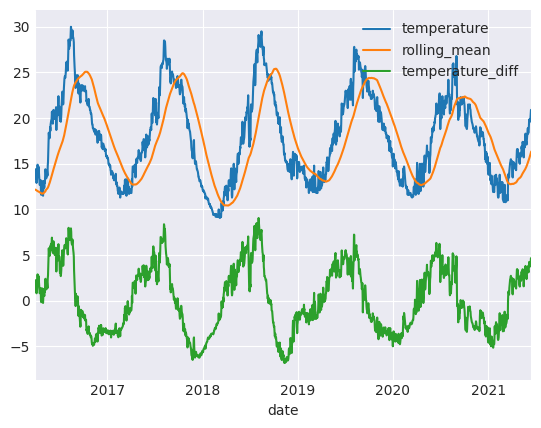

In [16]:
data = data.dropna()
data['temperature_diff'] = data['temperature'] - data['rolling_mean']
data.plot()

In [17]:
class TimeSeriesDatasetMulti(Dataset):
  def __init__(self, ts:np.array, lookback_size:int, forecast_size:int):
    self.lookback_size = lookback_size
    self.forecast_size = forecast_size
    self.data = ts

  def __len__(self):
    return len(self.data) - self.lookback_size - self.forecast_size + 1

  def __getitem__(self, i):
    idx = (i + self.lookback_size)
    look_back = self.data[i:idx]
    forecast = self.data[idx:idx + self.forecast_size]
    return look_back, forecast
  
class NetMulti(nn.Module):
  def __init__(self, d_in, d_out, d_hidden1, d_hidden2, d_hidden3, c_in, activation=F.relu):
    super().__init__()
    self.lin1 = nn.Linear(d_in*c_in, d_hidden1)
    self.lin2 = nn.Linear(d_hidden1, d_hidden2)
    self.lin3 = nn.Linear(d_hidden2, d_hidden3)
    self.lin4 = nn.Linear(d_hidden3, d_out*c_in)
    self.activation = activation
    self.c_in = c_in
    self.d_out = d_out

  def forward(self, x):
    x = x.flatten(1)
    x = self.lin1(x)
    x = self.activation(x)
    x = self.lin2(x)
    x = self.activation(x)
    x = self.lin3(x)
    x = self.activation(x)
    x = self.lin4(x).reshape(-1, self.d_out, self.c_in)
    return x

def mape(y_pred, y_true):
  return (np.abs(y_pred - y_true)/y_true).mean() * 100

def mae(y_pred, y_true):
  return np.abs(y_pred - y_true).mean()

def mse(y_pred, y_true):
  return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

def rmse(y_pred, y_true):
  return np.sqrt(mse(y_pred, y_true))

def r_squared(y_pred, y_true):
  return r2_score(y_true, y_pred)

def r2_score(y_pred, y_true):
  ss_tot = np.sum((y_true - np.mean(y_true))**2)
  ss_res = np.sum((y_true - y_pred)**2)
  r2 = 1 - (ss_res / ss_tot)
  return r2

In [18]:
def generate_time_series_loaders(pred_size, lookback_size, forecast_size):
    trn_df = data[:-pred_size].to_numpy(dtype=np.float32)
    tst_df = data[-pred_size - lookback_size:].to_numpy(dtype=np.float32)
    tst_y = tst_df[-pred_size:]

    # non-scaling
    trn_Ods = TimeSeriesDatasetMulti(trn_df, lookback_size, forecast_size)
    tst_Ods = TimeSeriesDatasetMulti(tst_df, lookback_size, forecast_size)

    trn_Odl = DataLoader(trn_Ods, batch_size=32, shuffle=True)
    tst_Odl = DataLoader(tst_Ods, batch_size=pred_size, shuffle=False)

    # scaling
    scaler = MinMaxScaler()
    trn_scaled = scaler.fit_transform(data[:-pred_size].to_numpy(dtype=np.float32))
    tst_scaled = scaler.transform(data[-pred_size-lookback_size:].to_numpy(dtype=np.float32))

    trn_ds = TimeSeriesDatasetMulti(trn_scaled, lookback_size, forecast_size)

    trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)

    return tst_y, trn_Ods, tst_Ods, trn_Odl, tst_Odl, trn_ds, trn_dl

# Hyper Parameter
### pred_size = 15, 30, 60, 90

In [19]:
'''
order_list = [
    [15, 5, 1, 512, 128, 32, 3, 200, 0.0001], [15, 5, 1, 512, 128, 32, 3, 400, 0.0001], [15, 5, 1, 512, 128, 32, 3, 850, 0.0001], 
    [15, 5, 5, 512, 128, 32, 3, 200, 0.0001], [15, 5, 5, 512, 128, 32, 3, 400, 0.0001], [15, 5, 5, 512, 128, 32, 3, 850, 0.0001], 
    [15, 5, 15, 512, 128, 32, 3,200, 0.0001], [15, 5, 15, 512, 128, 32, 3, 400, 0.0001], [15, 5, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [15, 15, 1, 512, 128, 32, 3, 200, 0.0001], [15, 15, 1, 512, 128, 32, 3, 400, 0.0001], [15, 15, 1, 512, 128, 32, 3, 850, 0.0001], 
    [15, 15, 5, 512, 128, 32, 3, 200, 0.0001], [15, 15, 5, 512, 128, 32, 3, 400, 0.0001], [15, 15, 5, 512, 128, 32, 3, 850, 0.0001], 
    [15, 15, 15, 512, 128, 32, 3, 200, 0.0001], [15, 15, 15, 512, 128, 32, 3, 400, 0.0001], [15, 15, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [15, 30, 1, 512, 128, 32, 3, 200, 0.0001], [15, 30, 1, 512, 128, 32, 3, 400, 0.0001], [15, 30, 1, 512, 128, 32, 3, 850, 0.0001], 
    [15, 30, 5, 512, 128, 32, 3, 200, 0.0001], [15, 30, 5, 512, 128, 32, 3, 400, 0.0001], [15, 30, 5, 512, 128, 32, 3, 850, 0.0001], 
    [15, 30, 15, 512, 128, 32, 3, 200, 0.0001], [15, 30, 15, 512, 128, 32, 3, 400, 0.0001], [15, 30, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [15, 90, 1, 512, 128, 32, 3, 200, 0.0001], [15, 90, 1, 512, 128, 32, 3, 400, 0.0001], [15, 90, 1, 512, 128, 32, 3, 850, 0.0001], 
    [15, 90, 5, 512, 128, 32, 3, 200, 0.0001], [15, 90, 5, 512, 128, 32, 3, 400, 0.0001], [15, 90, 5, 512, 128, 32, 3, 850, 0.0001], 
    [15, 90, 15, 512, 128, 32, 3, 200, 0.0001], [15, 90, 15, 512, 128, 32, 3, 400, 0.0001], [15, 90, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [30, 5, 1, 512, 128, 32, 3, 200, 0.0001], [30, 5, 1, 512, 128, 32, 3, 400, 0.0001], [30, 5, 1, 512, 128, 32, 3, 850, 0.0001], 
    [30, 5, 5, 512, 128, 32, 3, 200, 0.0001], [30, 5, 5, 512, 128, 32, 3, 400, 0.0001], [30, 5, 5, 512, 128, 32, 3, 850, 0.0001], 
    [30, 5, 15, 512, 128, 32, 3, 200, 0.0001], [30, 5, 15, 512, 128, 32, 3, 400, 0.0001], [30, 5, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [30, 15, 1, 512, 128, 32, 3, 200, 0.0001], [30, 15, 1, 512, 128, 32, 3, 400, 0.0001], [30, 15, 1, 512, 128, 32, 3, 850, 0.0001], 
    [30, 15, 5, 512, 128, 32, 3, 200, 0.0001], [30, 15, 5, 512, 128, 32, 3, 400, 0.0001], [30, 15, 5, 512, 128, 32, 3, 850, 0.0001], 
    [30, 15, 15, 512, 128, 32, 3, 200, 0.0001], [30, 15, 15, 512, 128, 32, 3, 400, 0.0001], [30, 15, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [30, 30, 1, 512, 128, 32, 3, 200, 0.0001], [30, 30, 1, 512, 128, 32, 3, 400, 0.0001], [30, 30, 1, 512, 128, 32, 3, 850, 0.0001], 
    [30, 30, 5, 512, 128, 32, 3, 200, 0.0001], [30, 30, 5, 512, 128, 32, 3, 400, 0.0001], [30, 30, 5, 512, 128, 32, 3, 850, 0.0001], 
    [30, 30, 15, 512, 128, 32, 3, 200, 0.0001], [30, 30, 15, 512, 128, 32, 3, 400, 0.0001], [30, 30, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [30, 90, 1, 512, 128, 32, 3, 200, 0.0001], [30, 90, 1, 512, 128, 32, 3, 400, 0.0001], [30, 90, 1, 512, 128, 32, 3, 850, 0.0001], 
    [30, 90, 5, 512, 128, 32, 3, 200, 0.0001], [30, 90, 5, 512, 128, 32, 3, 400, 0.0001], [30, 90, 5, 512, 128, 32, 3, 850, 0.0001], 
    [30, 90, 15, 512, 128, 32, 3, 200, 0.0001], [30, 90, 15, 512, 128, 32, 3, 400, 0.0001], [30, 90, 15, 512, 128, 32, 3, 850, 0.0001]

    [60, 5, 1, 512, 128, 32, 3, 200, 0.0001], [60, 5, 1, 512, 128, 32, 3, 400, 0.0001], [60, 5, 1, 512, 128, 32, 3, 850, 0.0001], 
    [60, 5, 5, 512, 128, 32, 3, 200, 0.0001], [60, 5, 5, 512, 128, 32, 3, 400, 0.0001], [60, 5, 5, 512, 128, 32, 3, 850, 0.0001], 
    [60, 5, 15, 512, 128, 32, 3, 200, 0.0001], [60, 5, 15, 512, 128, 32, 3, 400, 0.0001], [60, 5, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [60, 15, 1, 512, 128, 32, 3, 200, 0.0001], [60, 15, 1, 512, 128, 32, 3, 400, 0.0001], [60, 15, 1, 512, 128, 32, 3, 850, 0.0001], 
    [60, 15, 5, 512, 128, 32, 3, 200, 0.0001], [60, 15, 5, 512, 128, 32, 3, 400, 0.0001], [60, 15, 5, 512, 128, 32, 3, 850, 0.0001], 
    [60, 15, 15, 512, 128, 32, 3, 200, 0.0001], [60, 15, 15, 512, 128, 32, 3, 400, 0.0001], [60, 15, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [60, 30, 1, 512, 128, 32, 3, 200, 0.0001], [60, 30, 1, 512, 128, 32, 3, 400, 0.0001], [60, 30, 1, 512, 128, 32, 3, 850, 0.0001], 
    [60, 30, 5, 512, 128, 32, 3, 200, 0.0001], [60, 30, 5, 512, 128, 32, 3, 400, 0.0001], [60, 30, 5, 512, 128, 32, 3, 850, 0.0001], 
    [60, 30, 15, 512, 128, 32, 3, 200, 0.0001], [60, 30, 15, 512, 128, 32, 3, 400, 0.0001], [60, 30, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [60, 90, 1, 512, 128, 32, 3, 200, 0.0001], [60, 90, 1, 512, 128, 32, 3, 400, 0.0001], [60, 90, 1, 512, 128, 32, 3, 850, 0.0001], 
    [60, 90, 5, 512, 128, 32, 3, 200, 0.0001], [60, 90, 5, 512, 128, 32, 3, 400, 0.0001], [60, 90, 5, 512, 128, 32, 3, 850, 0.0001], 
    [60, 90, 15, 512, 128, 32, 3, 200, 0.0001], [60, 90, 15, 512, 128, 32, 3, 400, 0.0001], [60, 90, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [90, 5, 1, 512, 128, 32, 3, 200, 0.0001], [90, 5, 1, 512, 128, 32, 3, 400, 0.0001], [90, 5, 1, 512, 128, 32, 3, 850, 0.0001], 
    [90, 5, 5, 512, 128, 32, 3, 200, 0.0001], [90, 5, 5, 512, 128, 32, 3, 400, 0.0001], [90, 5, 5, 512, 128, 32, 3, 850, 0.0001], 
    [90, 5, 15, 512, 128, 32, 3, 200, 0.0001], [90, 5, 15, 512, 128, 32, 3, 400, 0.0001], [90, 5, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [90, 15, 1, 512, 128, 32, 3, 200, 0.0001], [90, 15, 1, 512, 128, 32, 3, 400, 0.0001], [90, 15, 1, 512, 128, 32, 3, 850, 0.0001], 
    [90, 15, 5, 512, 128, 32, 3, 200, 0.0001], [90, 15, 5, 512, 128, 32, 3, 400, 0.0001], [90, 15, 5, 512, 128, 32, 3, 850, 0.0001], 
    [90, 15, 15, 512, 128, 32, 3, 200, 0.0001], [90, 15, 15, 512, 128, 32, 3, 400, 0.0001], [90, 15, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [90, 30, 1, 512, 128, 32, 3, 200, 0.0001], [90, 30, 1, 512, 128, 32, 3, 400, 0.0001], [90, 30, 1, 512, 128, 32, 3, 850, 0.0001], 
    [90, 30, 5, 512, 128, 32, 3, 200, 0.0001], [90, 30, 5, 512, 128, 32, 3, 400, 0.0001], [90, 30, 5, 512, 128, 32, 3, 850, 0.0001], 
    [90, 30, 15, 512, 128, 32, 3, 200, 0.0001], [90, 30, 15, 512, 128, 32, 3, 400, 0.0001],[90, 30, 15, 512, 128, 32, 3, 850, 0.0001], 
    
    [90, 90, 1, 512, 128, 32, 3, 200, 0.0001], [90, 90, 1, 512, 128, 32, 3, 400, 0.0001], [90, 90, 1, 512, 128, 32, 3, 850, 0.0001], 
    [90, 90, 5, 512, 128, 32, 3, 200, 0.0001], [90, 90, 5, 512, 128, 32, 3, 400, 0.0001], [90, 90, 5, 512, 128, 32, 3, 850, 0.0001], 
    [90, 90, 15, 512, 128, 32, 3, 200, 0.0001], [90, 90, 15, 512, 128, 32, 3, 400, 0.0001], [90, 90, 15, 512, 128, 32, 3, 850, 0.0001]
]
'''

'\norder_list = [\n    [15, 5, 1, 512, 128, 32, 3, 200, 0.0001], [15, 5, 1, 512, 128, 32, 3, 400, 0.0001], [15, 5, 1, 512, 128, 32, 3, 850, 0.0001], \n    [15, 5, 5, 512, 128, 32, 3, 200, 0.0001], [15, 5, 5, 512, 128, 32, 3, 400, 0.0001], [15, 5, 5, 512, 128, 32, 3, 850, 0.0001], \n    [15, 5, 15, 512, 128, 32, 3,200, 0.0001], [15, 5, 15, 512, 128, 32, 3, 400, 0.0001], [15, 5, 15, 512, 128, 32, 3, 850, 0.0001], \n    \n    [15, 15, 1, 512, 128, 32, 3, 200, 0.0001], [15, 15, 1, 512, 128, 32, 3, 400, 0.0001], [15, 15, 1, 512, 128, 32, 3, 850, 0.0001], \n    [15, 15, 5, 512, 128, 32, 3, 200, 0.0001], [15, 15, 5, 512, 128, 32, 3, 400, 0.0001], [15, 15, 5, 512, 128, 32, 3, 850, 0.0001], \n    [15, 15, 15, 512, 128, 32, 3, 200, 0.0001], [15, 15, 15, 512, 128, 32, 3, 400, 0.0001], [15, 15, 15, 512, 128, 32, 3, 850, 0.0001], \n    \n    [15, 30, 1, 512, 128, 32, 3, 200, 0.0001], [15, 30, 1, 512, 128, 32, 3, 400, 0.0001], [15, 30, 1, 512, 128, 32, 3, 850, 0.0001], \n    [15, 30, 5, 512, 128, 32

# Model Fitting and Forecasting

pred_size: 15, lookback_size: 5, forecast_size: 1, hidden_dim1: 512, hidden_dim2: 128, hidden_dim3: 32, channel_size: 3, epoch: 200, lr: 0.0001


100%|██████████| 200/200 [00:24<00:00,  8.17it/s, Multi-channel trn_loss=0.205, tst_loss=0.0888, tst_mape=3.31, tst_mae=0.221, tst_rmse=0.298]


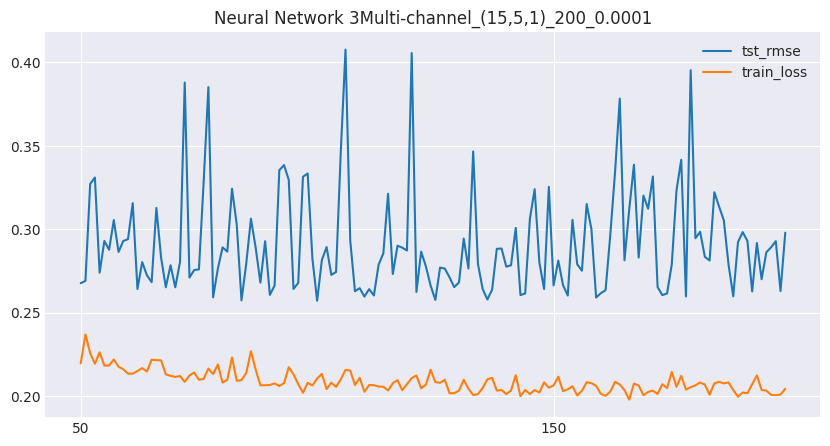

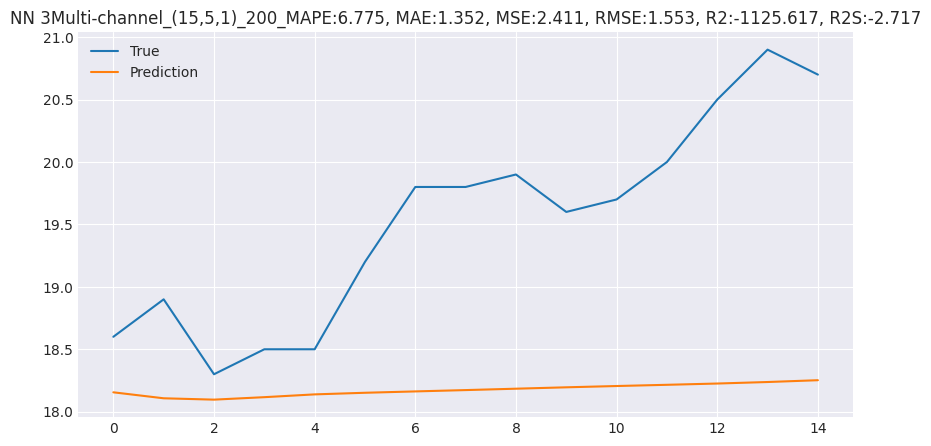

pred_size: 30, lookback_size: 15, forecast_size: 1, hidden_dim1: 512, hidden_dim2: 128, hidden_dim3: 32, channel_size: 3, epoch: 200, lr: 0.0001


100%|██████████| 200/200 [00:26<00:00,  7.45it/s, Multi-channel trn_loss=0.208, tst_loss=0.126, tst_mape=4.76, tst_mae=0.256, tst_rmse=0.356]


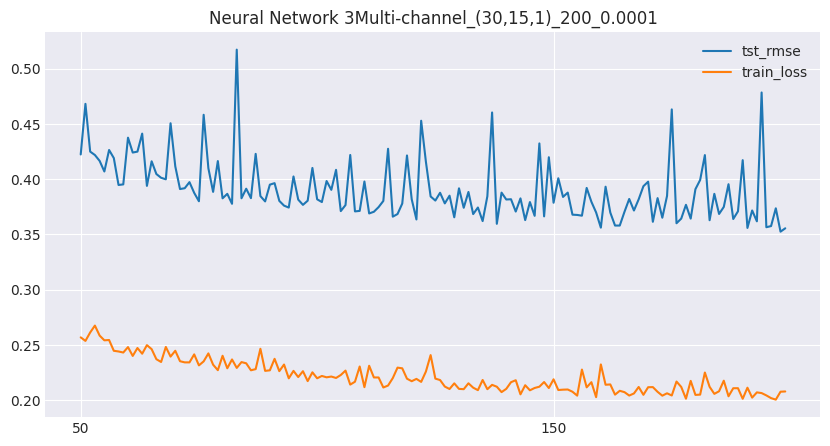

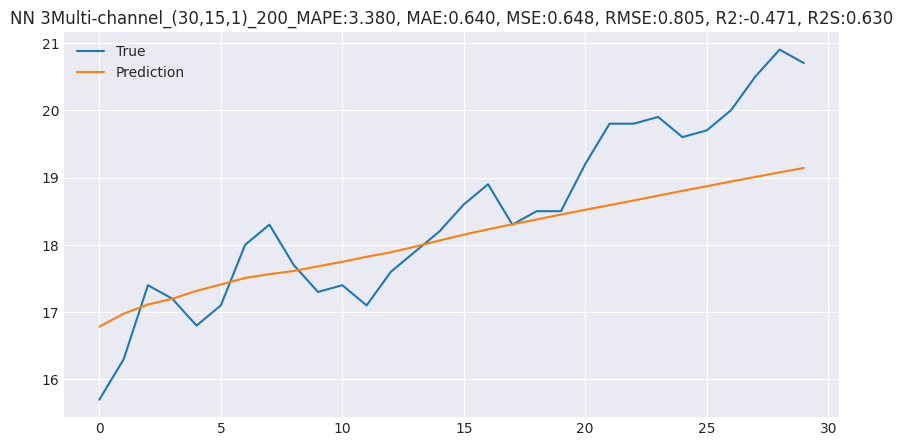

pred_size: 60, lookback_size: 30, forecast_size: 1, hidden_dim1: 512, hidden_dim2: 128, hidden_dim3: 32, channel_size: 3, epoch: 200, lr: 0.0001


100%|██████████| 200/200 [00:27<00:00,  7.17it/s, Multi-channel trn_loss=0.21, tst_loss=0.141, tst_mape=5.34, tst_mae=0.288, tst_rmse=0.376] 


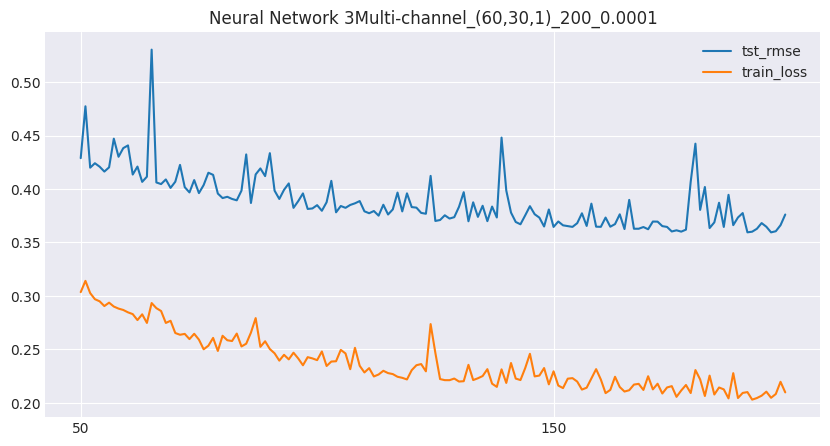

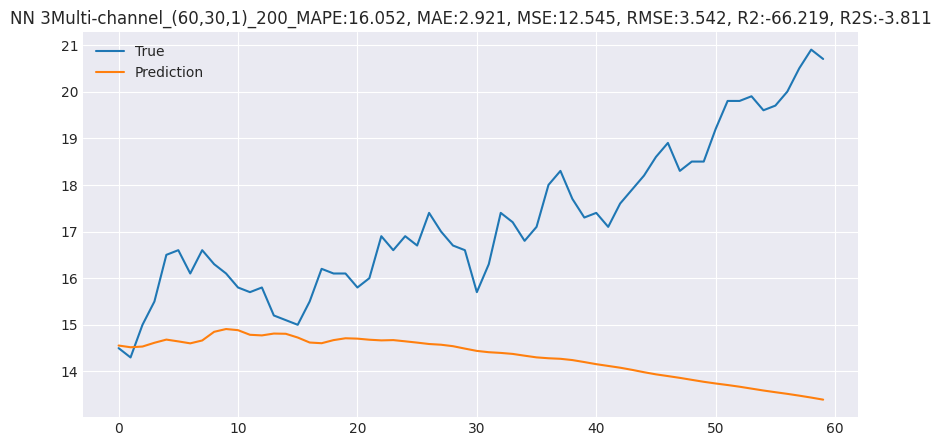

pred_size: 90, lookback_size: 90, forecast_size: 1, hidden_dim1: 512, hidden_dim2: 128, hidden_dim3: 32, channel_size: 3, epoch: 200, lr: 0.0001


100%|██████████| 200/200 [00:31<00:00,  6.28it/s, Multi-channel trn_loss=0.196, tst_loss=0.214, tst_mape=17.8, tst_mae=0.314, tst_rmse=0.463]


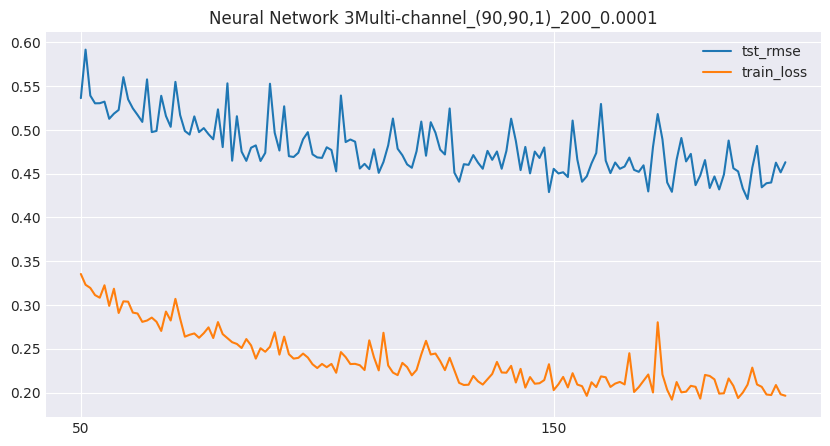

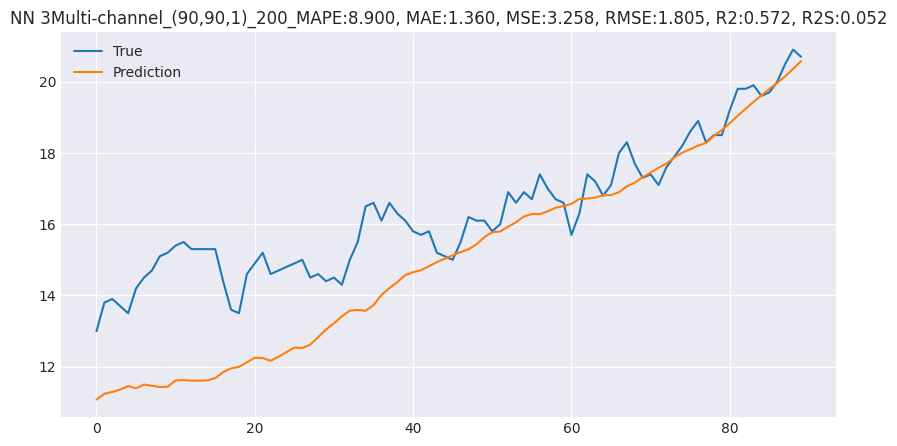

In [20]:
order_list = [[15, 5, 1, 512, 128, 32, 3, 200, 0.0001], [30, 15, 1, 512, 128, 32, 3, 200, 0.0001], [60, 30, 1, 512, 128, 32, 3, 200, 0.0001], [90, 90, 1, 512, 128, 32, 3, 200, 0.0001]]
cnt = 1

for pred_size, lookback_size, forecast_size, hidden_dim1, hidden_dim2, hidden_dim3, channel_size, epoch, lr in order_list:
	print(f'pred_size: {pred_size}, lookback_size: {lookback_size}, forecast_size: {forecast_size}, hidden_dim1: {hidden_dim1}, hidden_dim2: {hidden_dim2}, hidden_dim3: {hidden_dim3}, channel_size: {channel_size}, epoch: {epoch}, lr: {lr}')

	tst_y, trn_Ods, tst_Ods, trn_Odl, tst_Odl, trn_ds, trn_dl = generate_time_series_loaders(pred_size, lookback_size, forecast_size)

	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	
	net = NetMulti(lookback_size, forecast_size, hidden_dim1, hidden_dim2, hidden_dim3, channel_size)
	net.to(device)

	optim = torch.optim.AdamW(net.parameters(), lr=lr)
	pbar = trange(epoch)
	
	losses = []
	trn_losses = []
	tst_rmse_losses = []

	for i in pbar:
		net.train()
		trn_loss = .0

		for x, y in trn_Odl:
			x, y = x.to(device), y.to(device)
			p = net(x)
			optim.zero_grad()
			loss = F.mse_loss(p, y)
			loss.backward()
			optim.step()
			trn_loss += loss.item() * len(y)
		trn_loss = trn_loss / len(trn_Ods)

		net.eval()
		with torch.inference_mode():
			x, y = next(iter(tst_Odl))
			x, y = x.to(device), y.to(device)
			p = net(x)
			tst_loss = F.mse_loss(p, y) 
			y = y.cpu()
			p = p.cpu()    
			tst_mape = mape(p, y)
			tst_mae = mae(p, y)
			tst_rmse = rmse(p, y)
			tst_mse = mse(p, y)

		pbar.set_postfix({
			'Multi-channel trn_loss':trn_loss, 'tst_loss':tst_loss.item(), 'tst_mape':tst_mape.item(), 
			'tst_mae':tst_mae.item(), 'tst_rmse':tst_rmse.item()
		})
		tst_loss = tst_loss.cpu()  
		losses.append(tst_loss)
		trn_losses.append(trn_loss)
		tst_rmse_losses.append(tst_rmse)

	path = f'./NN_{channel_size}ch/model/model_ANN_{channel_size}multi_{cnt}.pth'
	torch.save(net.state_dict(), path)

	plot_start = 50     # 그래프 디테일하게 보기 위해 확대
	epochs_to_plot = range(plot_start, epoch)
	plt.figure(figsize=(10, 5))
	plt.title(f"Neural Network {channel_size}Multi-channel_({pred_size},{lookback_size},{forecast_size})_{epoch}_{lr}")
	# plt.plot(epochs_to_plot, losses[plot_start:], label='tst_loss')	# 실제 예측 시 사용안함. 필요여부에 따라 사용가능
	plt.plot(epochs_to_plot, tst_rmse_losses[plot_start:], label='tst_rmse')
	plt.plot(epochs_to_plot, trn_losses[plot_start:], label='train_loss')
	plt.xticks(range(plot_start, epoch, 100))
	plt.legend()
	plt.savefig(f'./NN_{channel_size}ch/fig/ANN_{channel_size}multi_loss_{years}_({pred_size},{lookback_size},{forecast_size})_{epoch}_{lr}_{cnt}.png')
	plt.show

	preds = []
	x, y = trn_Ods[len(trn_Ods)-1]
	
	net = NetMulti(lookback_size, forecast_size, hidden_dim1, hidden_dim2, hidden_dim3,channel_size)
	net.load_state_dict(torch.load(path))

	net.eval()
	for _ in range(int(pred_size/forecast_size)):
		if y.shape == (1, forecast_size, channel_size):
			y = y.squeeze(0)
		x = np.concatenate([x, y])[-lookback_size:]
		x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
		x_tensor.to(device)

		with torch.inference_mode():
			y = net(x_tensor).cpu()
		preds.append(y)

	preds = np.concatenate(preds)
	final_preds = preds[:,:,0].flatten()
	tst_y = tst_y[:,0]

	MAPE = mape(final_preds, tst_y)
	MAE = mae(final_preds, tst_y)
	MSE = mse(final_preds, tst_y)
	RMSE = rmse(final_preds, tst_y)
	R2 = r_squared(final_preds, tst_y)
	R2S = r2_score(final_preds, tst_y)
	result.append([(pred_size, lookback_size, forecast_size, epoch, lr), MAPE, MAE, MSE, RMSE, R2, R2S])

	plt.figure(figsize=(10, 5))
	plt.title(f"NN {channel_size}Multi-channel_({pred_size},{lookback_size},{forecast_size})_{epoch}_MAPE:{MAPE:.3f}, MAE:{MAE:.3f}, MSE:{MSE:.3f}, RMSE:{RMSE:.3f}, R2:{R2:.3f}, R2S:{R2S:.3f}")
	plt.plot(range(pred_size), tst_y, label="True")
	plt.plot(range(pred_size), final_preds, label="Prediction")
	plt.legend()
	plt.savefig(f'./NN_{channel_size}ch/result/ANN_{channel_size}multi_{years}_({pred_size},{lookback_size},{forecast_size})_{epoch}_{lr}_{cnt}.png')
	plt.show()

	cnt += 1

# 결과 DataFrame 생성

In [22]:
pd.set_option('float_format', '{:.4f}'.format)
result_df = pd.DataFrame(result, columns=['order', 'MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'R2S'])
result_df.set_index('order', inplace=True)
result_df.to_csv(f'./NN_{channel_size}ch/ANN_' + str(channel_size) + 'multi_result_' + years + '.csv')
result_df

,MAPE,MAE,MSE,RMSE,R2,R2S
order,,,,,,
"(15, 5, 1, 200, 0.0001)",6.7751,1.3522,2.4107,1.5526,-1125.6174,-2.7166
"(30, 15, 1, 200, 0.0001)",3.3798,0.6399,0.6484,0.8052,-0.4709,0.6304
"(60, 30, 1, 200, 0.0001)",16.0520,2.9205,12.5451,3.5419,-66.2186,-3.8111
"(90, 90, 1, 200, 0.0001)",8.9003,1.3600,3.2579,1.8050,0.5719,0.0521
